# Pet-project: "Предсказание стоимости жилья"

## Выполнил: Сорочайкин Александр Ярославович

## Подключение необходимых библиотек

In [731]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import optuna

from catboost import CatBoostRegressor

## Загрузка и разведочный анализ данных

### Загрузим данные

In [732]:
df = pd.read_csv('train.csv')

In [733]:
df.sample(5)

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,...,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
1279,Lvl,1980.0,1,698,0,6,TA,0,GasA,Norm,...,2,TA,1,1128,430,Y,TA,698,0,68400
914,Lvl,2009.0,2,612,294,4,Gd,234,GasA,Norm,...,2,Gd,1,1224,612,Y,Gd,612,0,173733
1257,Lvl,NaN,1,864,0,4,TA,96,GasA,Norm,...,0,TA,1,864,0,Y,Fa,864,0,99900
769,HLS,2003.0,3,1690,1416,12,Ex,36,GasA,Norm,...,3,Ex,1,3279,1589,Y,Gd,1650,1,538000
131,Lvl,2000.0,2,1022,695,7,Gd,48,GasA,Norm,...,2,Gd,1,2054,1032,Y,Gd,992,1,244000


In [734]:
df.shape

(1460, 21)

### Проверим данные на наличие пропусков

In [735]:
info = pd.DataFrame(index = df.columns)
info['Тип данных'] = df.dtypes
info['Количество уникальных значений'] = df.nunique()
info['Количество значений'] = df.count()
info['Количество пропущенных значений'] = df.isna().sum()
info

,Тип данных,Количество уникальных значений,Количество значений,Количество пропущенных значений
LandContour,object,4,1460,0
GarageYrBlt,float64,97,1379,81
FullBath,int64,4,1460,0
1stFlrSF,int64,753,1460,0
BsmtFinSF1,int64,637,1460,0
TotRmsAbvGrd,int64,12,1460,0
ExterQual,object,4,1460,0
OpenPorchSF,int64,202,1460,0
Heating,object,6,1460,0
Condition2,object,8,1460,0


In [736]:
df['GarageYrBlt'].fillna(df['GarageYrBlt'].median(), inplace=True)
df['BsmtQual'].fillna(df['BsmtQual'].mode()[0], inplace=True)

Выводы по изучению признаков:  

    1. Составлены списки признаков, по их типам
    2. Обнаружена и решена проблема пропущенных значений
    3. Признаки LandContour, ExterQual, Heating, Condition2, KitchenQual, CentralAir и BsmtQual - категориальные признаки, которые описаны не числовыми значениями -> требуют отдельных преобразований

### Построение описательной статистики для каждого из столбцов

In [737]:
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe

,count,mean,std,min,25%,50%,75%,max
GarageYrBlt,1460.0,1978.59,24.00,1900.0,1962.00,1980.0,2001.00,2010.00
FullBath,1460.0,1.57,0.55,0.0,1.00,2.0,2.00,3.00
1stFlrSF,1460.0,1162.63,386.59,334.0,882.00,1087.0,1391.25,4692.00
BsmtFinSF1,1460.0,443.64,456.10,0.0,0.00,383.5,712.25,5644.00
TotRmsAbvGrd,1460.0,6.52,1.63,2.0,5.00,6.0,7.00,14.00
OpenPorchSF,1460.0,46.66,66.26,0.0,0.00,25.0,68.00,547.00
OverallQual,1460.0,6.10,1.38,1.0,5.00,6.0,7.00,10.00
GarageCars,1460.0,1.77,0.75,0.0,1.00,2.0,2.00,4.00
KitchenAbvGr,1460.0,1.05,0.22,0.0,1.00,1.0,1.00,3.00
GrLivArea,1460.0,1515.46,525.48,334.0,1129.50,1464.0,1776.75,5642.00


## Изучим отдельно числовые и категориальные признаки

In [738]:
# Категориальные признаки
categorical_features = ['LandContour', 'ExterQual', 'Heating', 'Condition2', 'KitchenQual', 'CentralAir', 'BsmtQual']

# Числовые признаки
numerical_features = ['GarageYrBlt', 'FullBath', '1stFlrSF', 'BsmtFinSF1', 'TotRmsAbvGrd', 'OpenPorchSF', 'OverallQual', 'GarageCars', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', 'Fireplaces']

### Числовые признаки

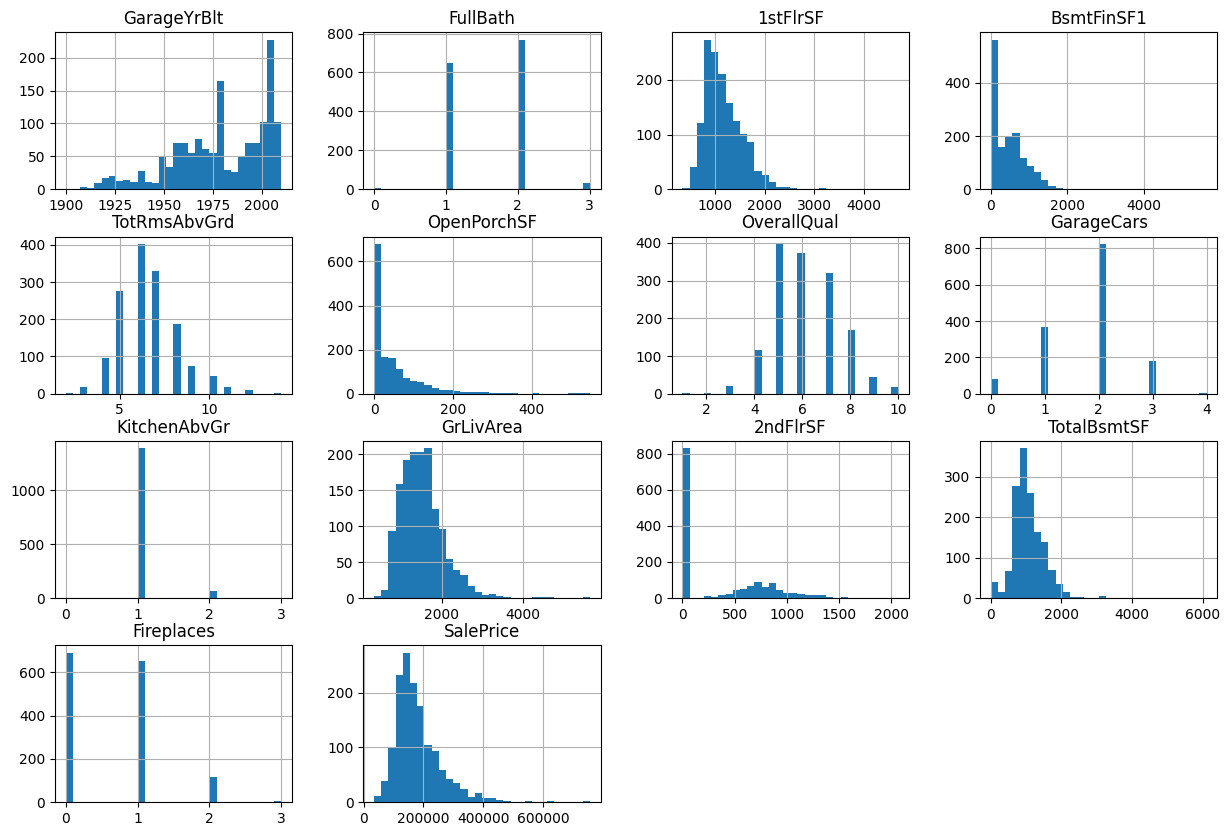

In [739]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

Видим, что отдельного внимания требуют следующие признаки:
1. 1stFlrSF, BsmtFinSF1, TotalBsmtSF, GrLivArea, SalePrice - рассмотреть в большем масштабе, похожи на графики с длинным хвостом - наличие потенциальных выбросов, однако, судя по природе данных, наличие аномальных значений может быть как раз обсуловлена природой данных
2. 2ndFlrSF - стоит рассмотреть отдельно. Количетсво домов с отсутствием второго этажа сильно превалирует, поэтому, возможно стоит преобразовать данный признак в бинарный.
3. KitchenAbvGr - скорее всего не информативен. Видим очень сильное преобладание одного из трех возможных значений.
4. OpenPorchSF - похож на площадь второго этажа, однако по графику, он более информативен. Однако стоит тоже задуматься о добавлении/преобразовании его в бинарный признак

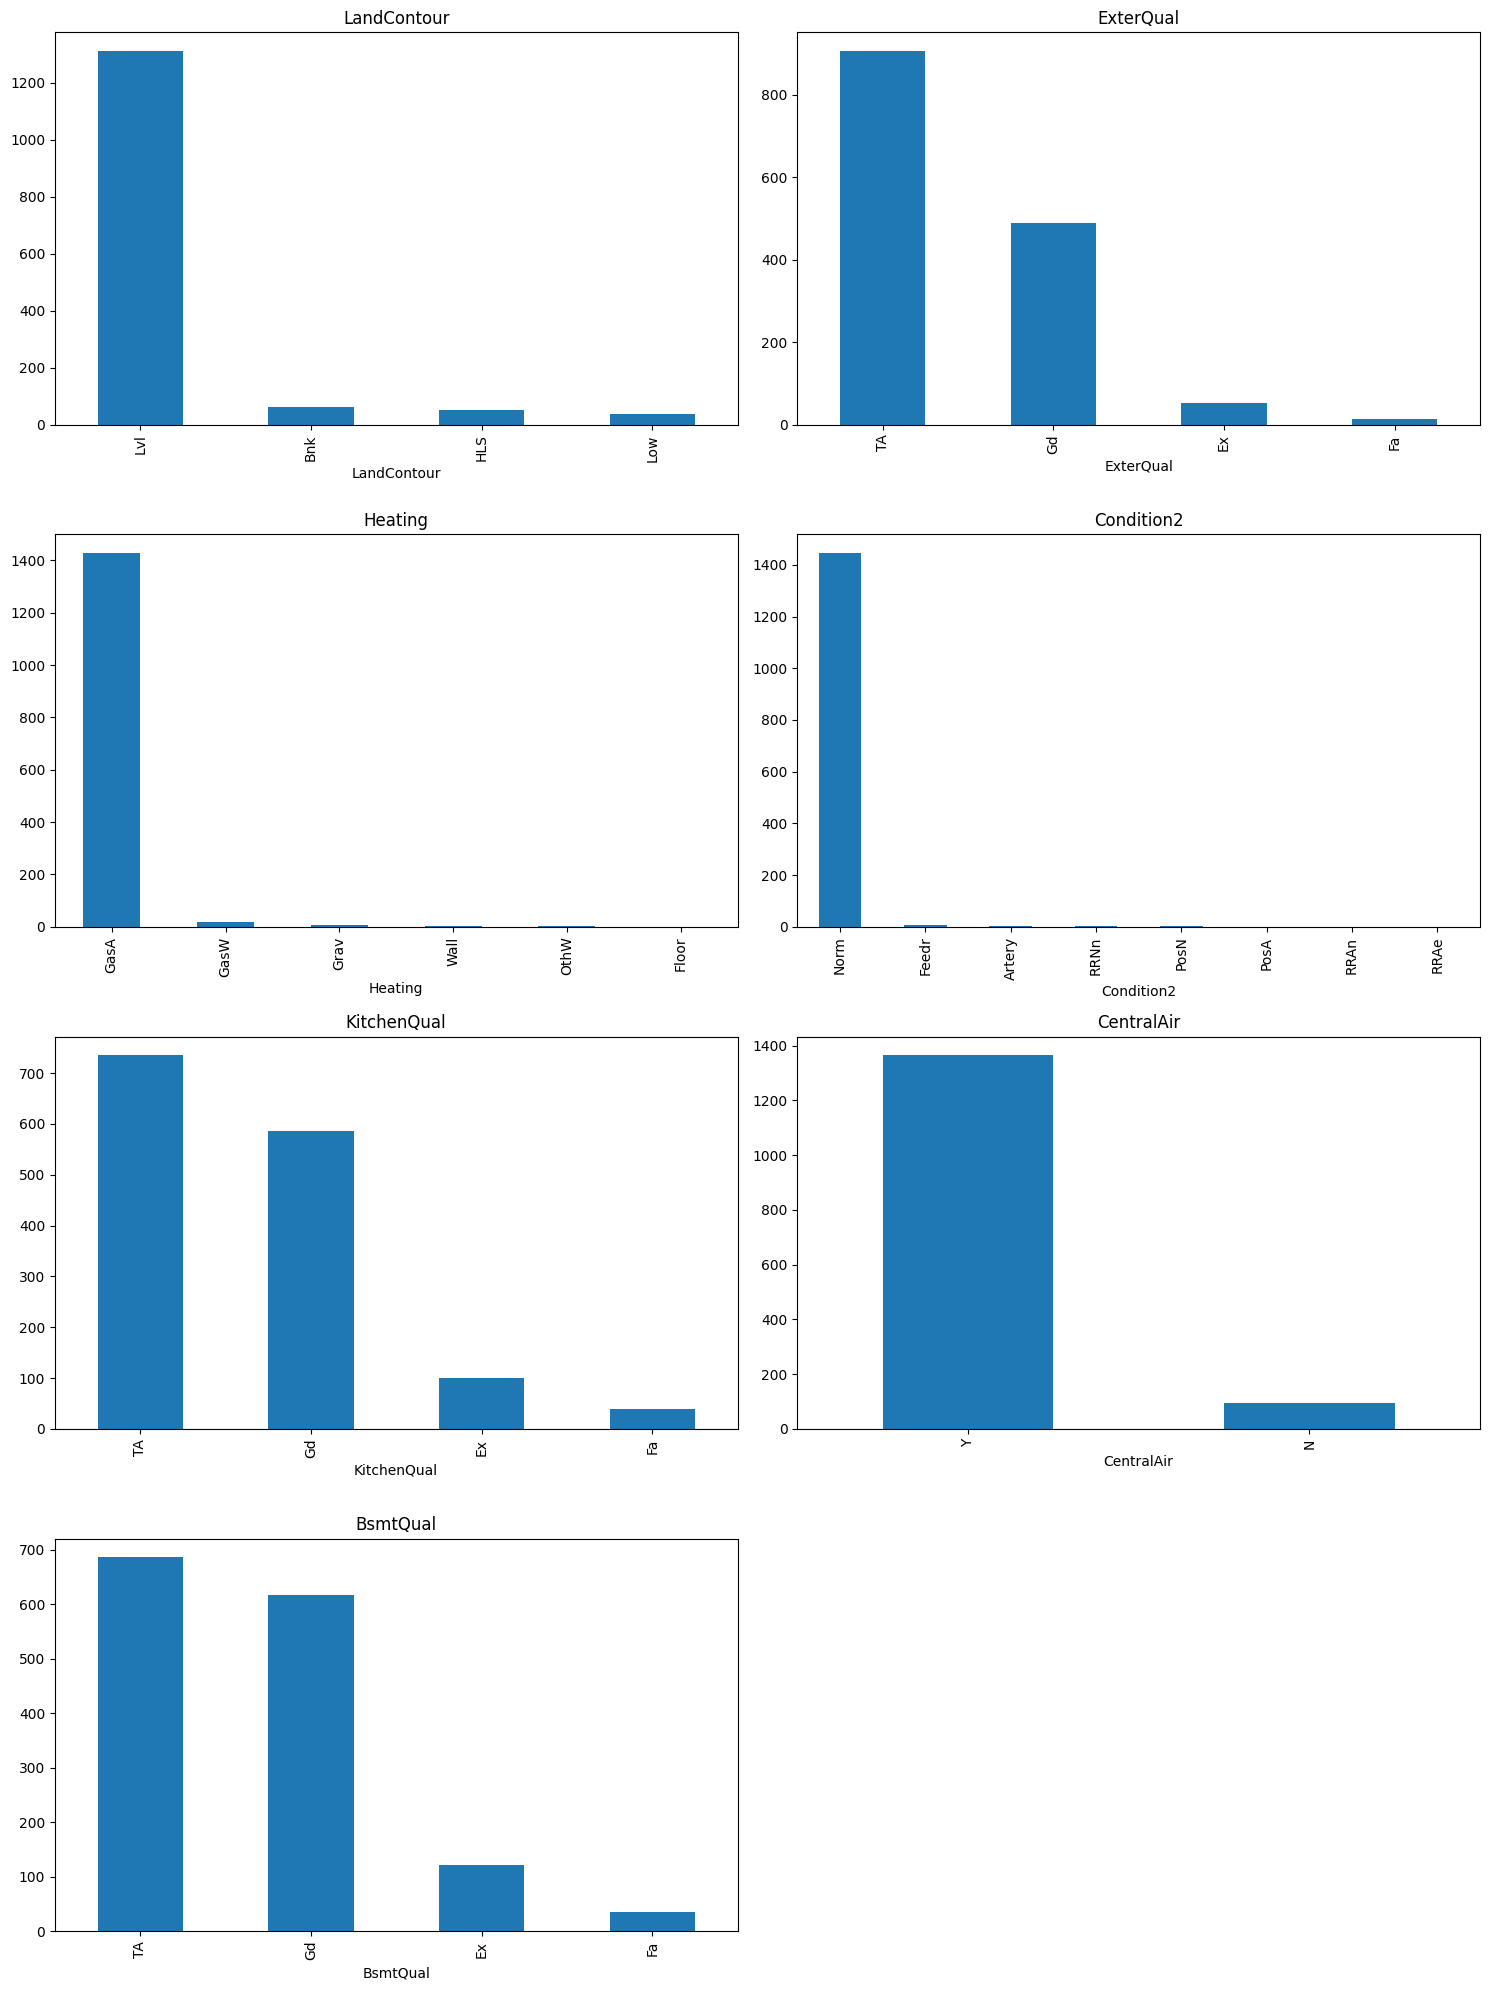

In [740]:
n_cols = 2  
n_rows = (len(categorical_features) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)

for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Выводы по категориальным признакам:
1. Признак LandContour выделяется сильным преобладанием одного из 4ех возможных значений. Стоит задуматься о его необходимости или его преобразовании в бинарный признак.
2. Признак Heating выделяется сильным преобладанием одного из 4ех возможных значений. Возможно, стоит избавиться от него
3. Признак Condition2 выделяется сильным преобладанием одного из возможных значений. Возможно, стоит избавиться от него
4. В признаке CentralAir также имеется сильное преобладание одного из двух значений. Возможно, он не слишком информативен.

### Рассмотрим столбцы 1stFlrSF, BsmtFinSF1, TotalBsmtSF, GrLivArea, SalePrice

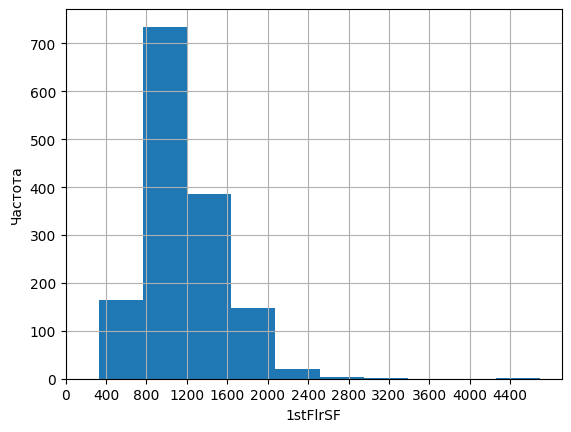

In [741]:
df['1stFlrSF'].hist(bins=10)
plt.xlabel('1stFlrSF')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['1stFlrSF'])+1, 400))

plt.show()

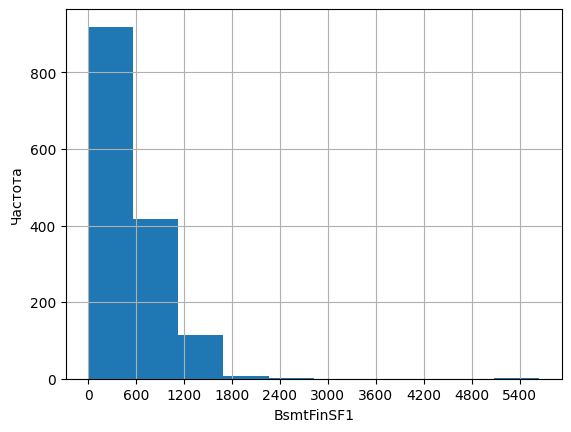

In [742]:
df['BsmtFinSF1'].hist(bins=10)
plt.xlabel('BsmtFinSF1')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['BsmtFinSF1'])+1, 600)) 
plt.show()

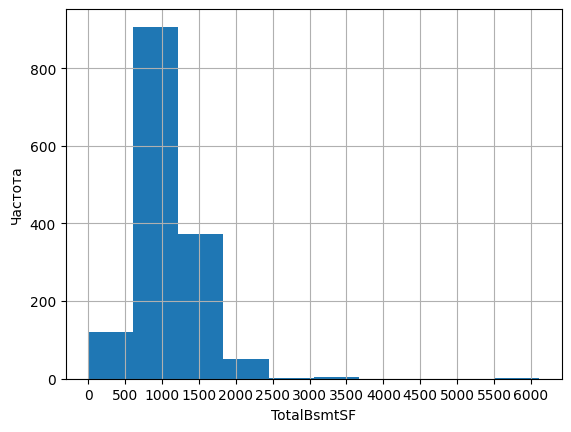

In [743]:
df['TotalBsmtSF'].hist(bins=10)
plt.xlabel('TotalBsmtSF')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['TotalBsmtSF'])+1, 500))  

plt.show()

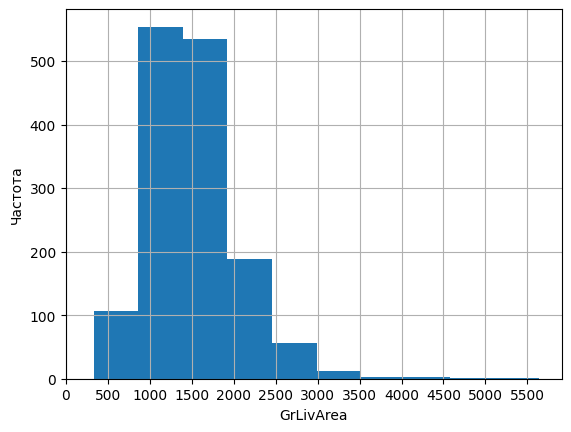

In [744]:
df['GrLivArea'].hist(bins=10)
plt.xlabel('GrLivArea')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['GrLivArea'])+1, 500))  

plt.show()

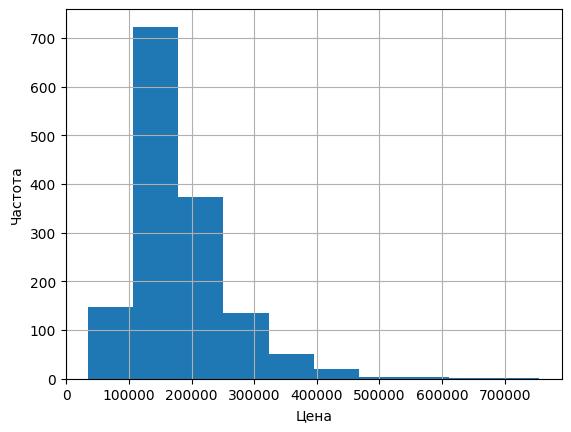

In [745]:
df['SalePrice'].hist(bins=10)
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['SalePrice'])+1, 100000)) 

plt.show()

Выводы по рассмотрению признаков 1stFlrSF, BsmtFinSF1, TotalBsmtSF, GrLivArea, SalePrice:
Гипотеза о том, что данные признаки являются распределениями с длинным хвостом не подтвердилась. Небольшие хвосты на графиках скорее всего объясняются природой данно, следовательно, не являются выбросами.

### Рассмотрим столбец 2ndFlrSF

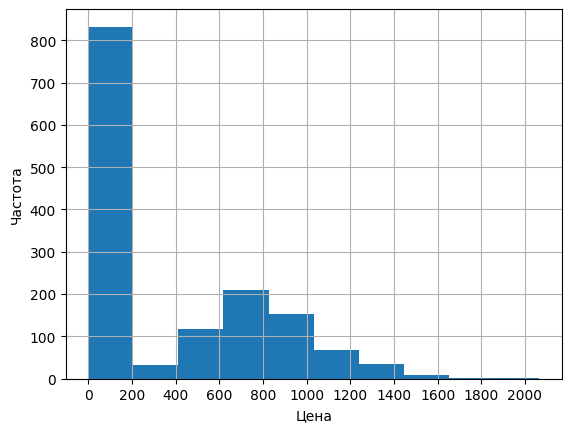

In [746]:
df['2ndFlrSF'].hist(bins=10)
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['2ndFlrSF'])+1, 200)) 

plt.show()

In [747]:
df['2ndFlrSF'].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

In [748]:
df[df['2ndFlrSF'] > 0]['2ndFlrSF'].describe()

count     631.000000
mean      802.866878
std       273.346959
min       110.000000
25%       625.000000
50%       776.000000
75%       926.500000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

Видим, что в исследуемом столбце более 50% значений - нулевые. Моежем преобразовать данный признак в категориальный, например, с тремя уникальными значениями: 0 - отсутствие второго этажа (площадь равна 0), а далее, получить две категории, основанные на исследовании оставишхся ненулевых значений: 1 - площадь от 0 до 780, 2 - площадь от 780 до 2065

### Рассмотрим столбец KitchenAbvGr

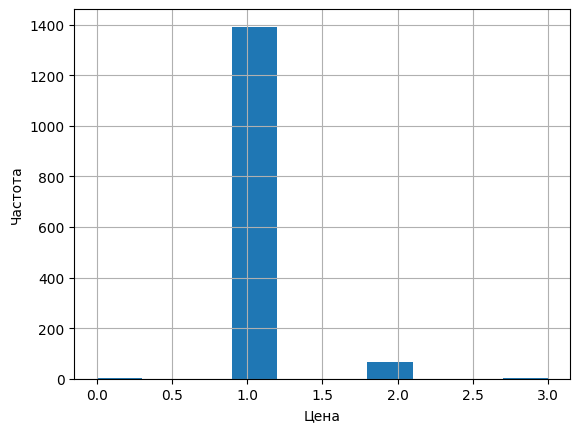

In [749]:
df['KitchenAbvGr'].hist(bins=10)
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.show()

In [750]:
df['KitchenAbvGr'].describe()

count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

In [751]:
df['KitchenAbvGr'].value_counts()

KitchenAbvGr
1    1392
2      65
3       2
0       1
Name: count, dtype: int64

Вывод по признаку KitchenAbvGr: Признак KitchenAbvGr не информативен, не имеет смысла использовать его при обучении модели.

### Рассмотрим столбец OpenPorchSF

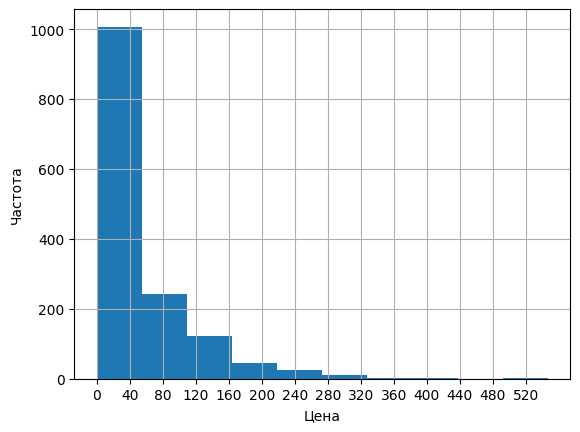

In [752]:
df['OpenPorchSF'].hist(bins=10)
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.xticks(range(0, max(df['OpenPorchSF'])+1, 40)) 

plt.show()

In [753]:
df['OpenPorchSF'].describe()

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [754]:
df[df['OpenPorchSF'] > 0]['OpenPorchSF'].describe()

count    804.000000
mean      84.731343
std       68.893171
min        4.000000
25%       39.000000
50%       63.000000
75%      112.000000
max      547.000000
Name: OpenPorchSF, dtype: float64

Вывод по рассмотрению признака OpenPorchSF:
Данный признак имеет не такую большую долю одного значения, как рассмотренные ранее и может быть использован в своем текущем виде. Однако, также может иметь смысл преобразование данного признака в категориальный признак следующим образом:
1. 0 - площадь 0
2. 1 - 0 < площадь <= 39
3. 2 - 39 < площадь <= 63
4. 3 - 63 < площадь

### Рассмотрим признак LandContour

In [755]:
df['LandContour'].value_counts()

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

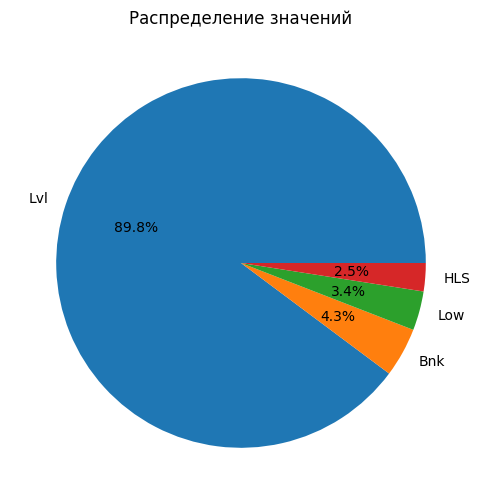

In [756]:
plt.figure(figsize=(6, 6))
plt.pie(df['LandContour'].value_counts(), labels = df['LandContour'].unique(), autopct='%1.1f%%')
plt.title('Распределение значений')
plt.show()

Имеет смысл преобразовать в бинарный, либо, исключить совсем

### Рассмотрим признак Heating

In [757]:
df['Heating'].value_counts()

Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64

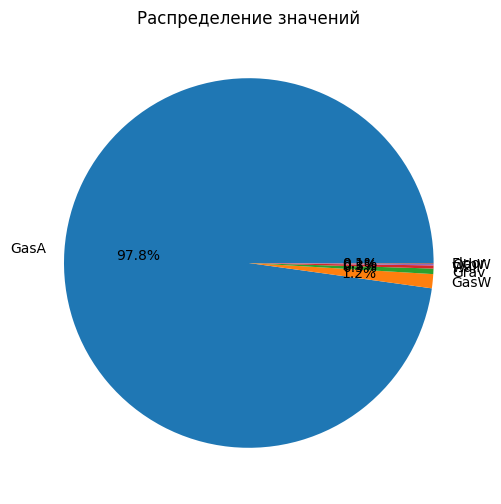

In [758]:
plt.figure(figsize=(6, 6))
plt.pie(df['Heating'].value_counts(), labels = df['Heating'].unique(), autopct='%1.1f%%')
plt.title('Распределение значений')
plt.show()

Признак не информативен, стоит исключить.

### Рассмотрим признак Condition2

In [759]:
df['Condition2'].value_counts()

Condition2
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64

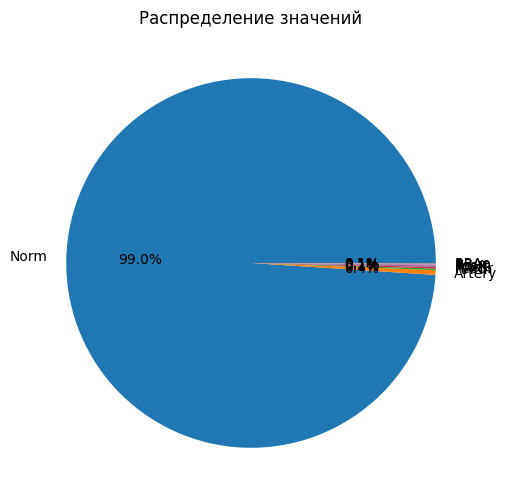

In [760]:
plt.figure(figsize=(6, 6))
plt.pie(df['Condition2'].value_counts(), labels = df['Condition2'].unique(), autopct='%1.1f%%')
plt.title('Распределение значений')
plt.show()

Признак не информативен. Стоит исключить

### Рассмотрим признак CentralAir

In [761]:
df['CentralAir'].value_counts()

CentralAir
Y    1365
N      95
Name: count, dtype: int64

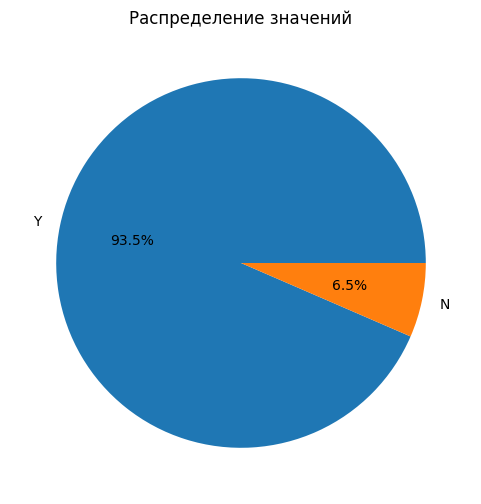

In [762]:
plt.figure(figsize=(6, 6))
plt.pie(df['CentralAir'].value_counts(), labels = df['CentralAir'].unique(), autopct='%1.1f%%')
plt.title('Распределение значений')
plt.show()

Потенциально, можно удалить

### Рассмотрим признак Fireplaces

In [763]:
df['Fireplaces'].value_counts()

Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64

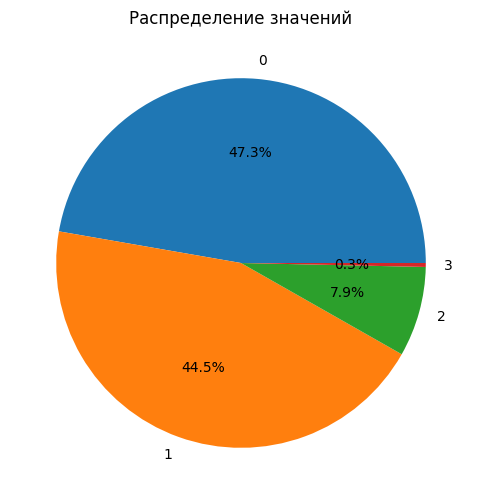

In [764]:
plt.figure(figsize=(6, 6))
plt.pie(df['Fireplaces'].value_counts(), labels = df['Fireplaces'].unique(), autopct='%1.1f%%')
plt.title('Распределение значений')
plt.show()

Возможно, имеет смысл преобразовать в бинарный признак

## Продолжаем исследование признаков

### Корреляционный анализ

In [765]:
# Оставшиеся численные признаки
new_numerical = ['GarageYrBlt', 'FullBath', '1stFlrSF', 'BsmtFinSF1',
       'TotRmsAbvGrd',
       'OverallQual', 'GarageCars', 'GrLivArea', 
                 'TotalBsmtSF',
       'SalePrice']

In [766]:
df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,...,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
0,Lvl,2003.0,2,856,706,8,Gd,61,GasA,Norm,...,2,Gd,1,1710,854,Y,Gd,856,0,208500
1,Lvl,1976.0,2,1262,978,6,TA,0,GasA,Norm,...,2,TA,1,1262,0,Y,Gd,1262,1,181500
2,Lvl,2001.0,2,920,486,6,Gd,42,GasA,Norm,...,2,Gd,1,1786,866,Y,Gd,920,1,223500
3,Lvl,1998.0,1,961,216,7,TA,35,GasA,Norm,...,3,Gd,1,1717,756,Y,TA,756,1,140000
4,Lvl,2000.0,2,1145,655,9,Gd,84,GasA,Norm,...,3,Gd,1,2198,1053,Y,Gd,1145,1,250000


In [767]:
df[new_numerical].head()

,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,OverallQual,GarageCars,GrLivArea,TotalBsmtSF,SalePrice
0,2003.0,2,856,706,8,7,2,1710,856,208500
1,1976.0,2,1262,978,6,6,2,1262,1262,181500
2,2001.0,2,920,486,6,7,2,1786,920,223500
3,1998.0,1,961,216,7,7,3,1717,756,140000
4,2000.0,2,1145,655,9,8,3,2198,1145,250000


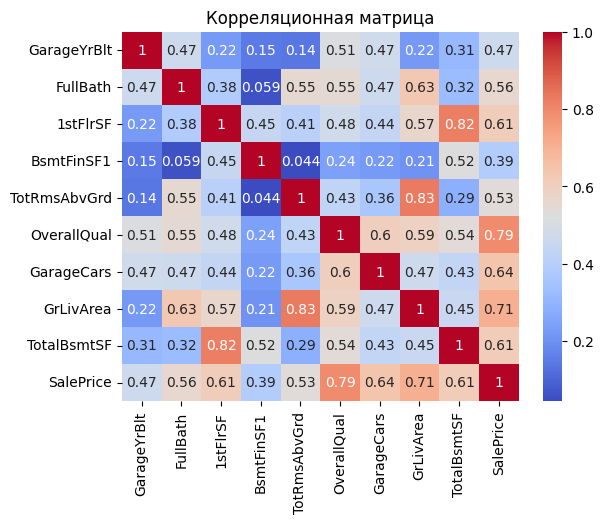

In [768]:
corr_matrix = df[new_numerical].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Выводы. 

1. Признаки TotalBsmtSF и 1stFlrSF имеют высокий коэффициент корреляции. Следовательно, имеет смысл либо убрать один из признаков, либо произвести некоторые преобразования. Например, TotalBsmtSF - площадь подвала, можно преобразовать в категориальных признак в зависимости от размеров подвала
2. Признаки TotRmsAbvGrd и GrLivArea имеют высокий коэффициент корреляции. Имеет смысл отбросить один из них. Пусть это будет TotRmsAbvGrd, как менее коррелирующий с целевой переменной признак

### Анализ на основе линейной регрессии

In [769]:
X = df[new_numerical].drop(columns=['SalePrice'])
y = df['SalePrice']

# Линейная регрессия
model = LinearRegression()
model.fit(X, y)

# Коэффициенты
coefficients = pd.Series(model.coef_, index=X.columns)
print(coefficients.sort_values(ascending=False))

OverallQual     22552.159168
GarageCars      15355.271107
TotRmsAbvGrd      832.347769
GarageYrBlt       262.900331
GrLivArea          43.861163
BsmtFinSF1         22.168908
TotalBsmtSF        12.111752
1stFlrSF           11.503108
FullBath         -440.979956
dtype: float64


По результатам анализа коэффициентов, имеет смысл проработать следующие признаки: 1stFlrSF, TotalBsmtSF, BsmtFinSF1, GrLivArea. Со всеми из них, кроме TotalBsmtSF действия уже предложены. Даный признак имеет смысл попробовать откинуть

### Анализ на основе Метод RFE (Recursive Feature Elimination)

In [770]:
rfe = RFE(model, n_features_to_select=1)

X = df[numerical_features]
y = df['SalePrice']

rfe.fit(X, y)

# Важность признаков
feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
print(feature_ranking.sort_values())

OverallQual      1
GarageCars       2
Fireplaces       3
FullBath         4
TotRmsAbvGrd     5
GarageYrBlt      6
1stFlrSF         7
2ndFlrSF         8
BsmtFinSF1       9
TotalBsmtSF     10
OpenPorchSF     11
GrLivArea       12
dtype: int64


### Подведем итог

**По итогу исследования, получены следующие группы столбцов:**

Дропаем: Heating, KitchenAbvGr, Condition2

Потенциально дропаем: CentralAir, LandContour,TotRmsAbvGrd, TotalBsmtSF

Преобразуем по своему:  2ndFlrSF, OpenPorchSF, LandContour

Потенциально преобразуем по своему: Fireplaces, TotalBsmtSF

Далее, нам необходимо написать функцию, которая преобразует наш датафрейм применив нужные нам изменения, а также, мы будем применять эту же функцию к тестовым данным, перед использованием их в модели

## Функция преобразования входных данных

In [771]:
df.columns

Index(['LandContour', 'GarageYrBlt', 'FullBath', '1stFlrSF', 'BsmtFinSF1',
       'TotRmsAbvGrd', 'ExterQual', 'OpenPorchSF', 'Heating', 'Condition2',
       'OverallQual', 'GarageCars', 'KitchenQual', 'KitchenAbvGr', 'GrLivArea',
       '2ndFlrSF', 'CentralAir', 'BsmtQual', 'TotalBsmtSF', 'Fireplaces',
       'SalePrice'],
      dtype='object')

In [772]:
def transform_dataframe(df, columns_to_drop):

    df = df.drop(columns=columns_to_drop)
    
    # Преобразуем столбец 'lvl'i
    df['LandContour'] = df['LandContour'].replace({'Lvl': 0, 'Bnk': 1, 'HLS': 1, 'Low': 1})
    
    # Применяем Label Encoder к столбцам 'ExterQual', 'KitchenQual', 'BsmtQual'
    label_encoder = LabelEncoder()
    for col in ['ExterQual', 'KitchenQual', 'BsmtQual']:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Преобразуем столбец '2ndFlrSF'
    df['2ndFlrSF'] = pd.cut(df['2ndFlrSF'], bins=[-1, 0, 780, 2065], labels=[0, 1, 2])
    
    # Преобразуем столбец 'OpenPorchSF'
    df['OpenPorchSF'] = pd.cut(df['OpenPorchSF'], bins=[-1, 0, 39, 63, float('inf')], labels=[0, 1, 2, 3])
    
    return df

In [773]:
df = transform_dataframe(df, ['KitchenAbvGr', 'Heating', 'Condition2', 'GrLivArea', 'TotalBsmtSF', 'CentralAir'])

## Изучение выбросов

Проверим гиппотезу, что имеющиеся "выбросы" (хвосты на графиках) - это на самом деле не выбросы, а природа данных

In [774]:
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe

,count,mean,std,min,25%,50%,75%,max
LandContour,1460.0,0.10,0.30,0.0,0.0,0.0,0.00,1.00
GarageYrBlt,1460.0,1978.59,24.00,1900.0,1962.0,1980.0,2001.00,2010.00
FullBath,1460.0,1.57,0.55,0.0,1.0,2.0,2.00,3.00
1stFlrSF,1460.0,1162.63,386.59,334.0,882.0,1087.0,1391.25,4692.00
BsmtFinSF1,1460.0,443.64,456.10,0.0,0.0,383.5,712.25,5644.00
TotRmsAbvGrd,1460.0,6.52,1.63,2.0,5.0,6.0,7.00,14.00
ExterQual,1460.0,2.54,0.69,0.0,2.0,3.0,3.00,3.00
OverallQual,1460.0,6.10,1.38,1.0,5.0,6.0,7.00,10.00
GarageCars,1460.0,1.77,0.75,0.0,1.0,2.0,2.00,4.00
KitchenQual,1460.0,2.34,0.83,0.0,2.0,3.0,3.00,3.00


In [775]:
number_extreme = pd.DataFrame()
list_index = []
list_values = []

for i in describe.index:
    tmp = describe['75%'].loc[i]
    list_index.append(i)
    list_values.append(df[df[i] > tmp][i].count()) 

number_extreme.index = list_index
number_extreme['Количество экстремальных значений'] = list_values
number_extreme.sort_values(by='Количество экстремальных значений', ascending=False)

,Количество экстремальных значений
1stFlrSF,365
BsmtFinSF1,365
SalePrice,362
GarageYrBlt,355
TotRmsAbvGrd,339
OverallQual,229
GarageCars,186
LandContour,149
Fireplaces,120
FullBath,33


In [776]:
selected_columns = df[['SalePrice','1stFlrSF','BsmtFinSF1','TotRmsAbvGrd','OverallQual','GarageCars']]
percentiles = selected_columns.quantile(0.75)
count2 = (((selected_columns > percentiles).sum(axis=1)) >= 2).sum()
count3 = (((selected_columns > percentiles).sum(axis=1)) >= 3).sum()
count4 = (((selected_columns > percentiles).sum(axis=1)) >= 4).sum()
print("n = 2: ", count2)
print("n = 3: ", count3)
print("n = 4: ", count4)

n = 2:  437
n = 3:  301
n = 4:  190


Видим, что максимальное количество экстримальных значений для отдельной категории - 365. Посчитали количество объектов, у которых сразу n параметров принимают экстримальные значений. Всего, было отобрано 6 значений. Как минимум 3 признака одновременно принимают экстримальные значения у 300 объектов, что немного меньше среднего количества экстримальных значений по выбранным признакам. Опираясь на это, можно предположить, что определення ранее гиппотеза - верна.

## Обработка аномальных значений

In [777]:
model = IsolationForest(contamination=0.05) 
model.fit(X)

anomaly_scores = model.decision_function(X)  

predictions = model.predict(X)  

df['Anomaly'] = predictions
anomalies_df = df[df['Anomaly'] == -1]

df = df[df['Anomaly'] == 1]
df.drop(columns=['Anomaly'], inplace=True)

In [778]:
anomalies_df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,OverallQual,GarageCars,KitchenQual,2ndFlrSF,BsmtQual,Fireplaces,SalePrice,Anomaly
11,0,2005.0,3,1182,998,11,0,1,9,3,0,2,0,2,345000,-1
28,0,1957.0,1,1600,1277,6,3,3,5,1,3,0,3,2,207500,-1
53,1,1981.0,0,1842,1810,5,2,3,9,3,2,0,0,1,385000,-1
58,1,2006.0,3,1426,0,10,0,0,10,3,2,2,0,1,438780,-1
70,0,1973.0,2,2223,1880,8,3,0,7,2,3,0,2,2,244000,-1


In [779]:
anomalies_df.describe()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OverallQual,GarageCars,KitchenQual,BsmtQual,Fireplaces,SalePrice,Anomaly
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,0.191781,1980.602740,2.164384,1692.287671,808.465753,9.232877,1.835616,7.328767,2.246575,1.520548,1.712329,1.273973,314489.945205,-1.0
std,0.396426,28.743956,0.726745,705.432304,890.471006,2.282302,1.178673,2.068647,0.968688,1.248439,1.306814,0.786347,160121.018023,0.0
min,0.000000,1908.000000,0.000000,334.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,-1.0
25%,0.000000,1972.000000,2.000000,1320.000000,0.000000,8.000000,1.000000,6.000000,2.000000,0.000000,0.000000,1.000000,200000.000000,-1.0
50%,0.000000,1988.000000,2.000000,1600.000000,575.000000,10.000000,2.000000,8.000000,2.000000,2.000000,2.000000,1.000000,299800.000000,-1.0
75%,0.000000,2004.000000,3.000000,2000.000000,1309.000000,11.000000,3.000000,9.000000,3.000000,3.000000,3.000000,2.000000,423000.000000,-1.0
max,1.000000,2009.000000,3.000000,4692.000000,5644.000000,14.000000,3.000000,10.000000,4.000000,3.000000,3.000000,3.000000,755000.000000,-1.0


## Обучение модели предсказания

### Линейная регрессия

In [780]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0)

model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 17833.9060, MSE: 318048204.7418, MAE: 19910.1710, R²: 0.8369


#### График предсказанных vs фактических значений на тестовой выборке

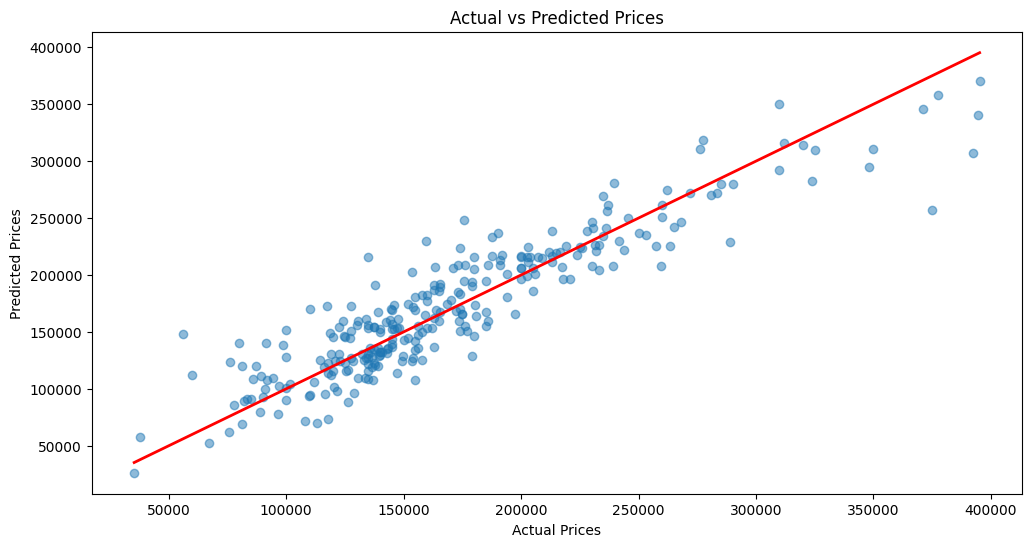

In [781]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

#### Визуализация коэффициентов модели

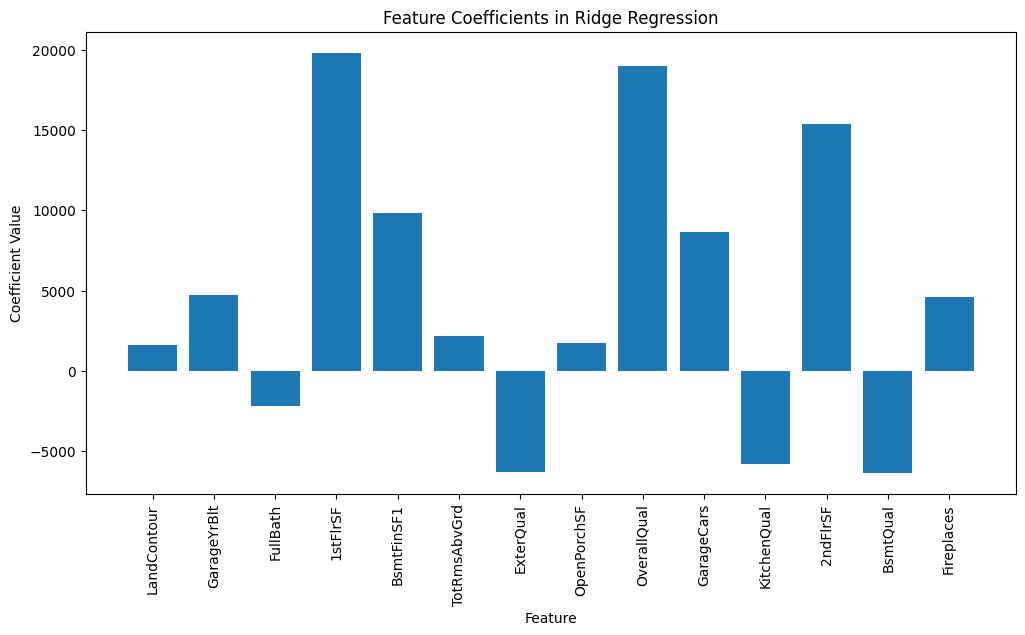

In [782]:
feature_names = X.columns
plt.figure(figsize=(12, 6))
plt.bar(feature_names, model.coef_)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients in Ridge Regression')
plt.xticks(rotation=90)
plt.show()

### CatBoost

In [783]:
cat_features = ['OpenPorchSF','2ndFlrSF','LandContour','ExterQual', 'KitchenQual', 'BsmtQual']  # Добавьте все категориальные признаки, которые есть в вашем датасете


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
    }

    model = CatBoostRegressor(**params, loss_function='RMSE', verbose=False)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

    return mse

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=40)

best_params = study.best_params
print("Лучшие параметры:", best_params)


[I 2024-05-19 18:35:10,744] A new study created in memory with name: no-name-3e3fff98-26c5-4ea7-8da7-e6c366ddd9d2
[I 2024-05-19 18:35:11,750] Trial 0 finished with value: 613566662.6247642 and parameters: {'iterations': 624, 'learning_rate': 0.01311370663739029, 'depth': 7, 'l2_leaf_reg': 0.32462899729633354}. Best is trial 0 with value: 613566662.6247642.


RMSE: 24770.2778, MSE: 613566662.6248, MAE: 17662.0742, R²: 0.8548


[I 2024-05-19 18:35:13,234] Trial 1 finished with value: 696641269.0373379 and parameters: {'iterations': 338, 'learning_rate': 0.0495875580528829, 'depth': 9, 'l2_leaf_reg': 1.5324843670994672}. Best is trial 0 with value: 613566662.6247642.


RMSE: 26393.9627, MSE: 696641269.0373, MAE: 18164.1560, R²: 0.8351


[I 2024-05-19 18:35:13,665] Trial 2 finished with value: 609919722.858432 and parameters: {'iterations': 451, 'learning_rate': 0.016274685900413487, 'depth': 5, 'l2_leaf_reg': 0.13827045319086084}. Best is trial 2 with value: 609919722.858432.


RMSE: 24696.5529, MSE: 609919722.8584, MAE: 18009.5235, R²: 0.8557


[I 2024-05-19 18:35:14,506] Trial 3 finished with value: 617031166.3944151 and parameters: {'iterations': 536, 'learning_rate': 0.021164335896404943, 'depth': 7, 'l2_leaf_reg': 0.10055875321970485}. Best is trial 2 with value: 609919722.858432.


RMSE: 24840.1120, MSE: 617031166.3944, MAE: 17791.4646, R²: 0.8540


[I 2024-05-19 18:35:14,861] Trial 4 finished with value: 601999543.8122582 and parameters: {'iterations': 360, 'learning_rate': 0.020114540203114973, 'depth': 5, 'l2_leaf_reg': 0.14720051245054058}. Best is trial 4 with value: 601999543.8122582.


RMSE: 24535.6790, MSE: 601999543.8123, MAE: 17995.1251, R²: 0.8575


[I 2024-05-19 18:35:16,295] Trial 5 finished with value: 652225499.5779794 and parameters: {'iterations': 323, 'learning_rate': 0.030979787597378804, 'depth': 9, 'l2_leaf_reg': 0.6547914665986939}. Best is trial 4 with value: 601999543.8122582.


RMSE: 25538.7059, MSE: 652225499.5780, MAE: 17881.6451, R²: 0.8456


[I 2024-05-19 18:35:19,269] Trial 6 finished with value: 640315694.4706956 and parameters: {'iterations': 699, 'learning_rate': 0.22711222892893865, 'depth': 10, 'l2_leaf_reg': 0.9539235527730352}. Best is trial 4 with value: 601999543.8122582.


RMSE: 25304.4600, MSE: 640315694.4707, MAE: 18277.1786, R²: 0.8485


[I 2024-05-19 18:35:19,475] Trial 7 finished with value: 633262936.9706072 and parameters: {'iterations': 163, 'learning_rate': 0.0479426302282532, 'depth': 8, 'l2_leaf_reg': 2.964937898501516}. Best is trial 4 with value: 601999543.8122582.


RMSE: 25164.7161, MSE: 633262936.9706, MAE: 18249.2662, R²: 0.8501


[I 2024-05-19 18:35:20,475] Trial 8 finished with value: 621513696.1481725 and parameters: {'iterations': 654, 'learning_rate': 0.013331435167984141, 'depth': 7, 'l2_leaf_reg': 0.17828995248164065}. Best is trial 4 with value: 601999543.8122582.


RMSE: 24930.1764, MSE: 621513696.1482, MAE: 17651.8005, R²: 0.8529


[I 2024-05-19 18:35:21,633] Trial 9 finished with value: 738243779.6666937 and parameters: {'iterations': 291, 'learning_rate': 0.02380755868791685, 'depth': 10, 'l2_leaf_reg': 8.46082958407775}. Best is trial 4 with value: 601999543.8122582.


RMSE: 27170.6419, MSE: 738243779.6667, MAE: 18861.8764, R²: 0.8253


[I 2024-05-19 18:35:22,338] Trial 10 finished with value: 575403652.527809 and parameters: {'iterations': 953, 'learning_rate': 0.11203086351593039, 'depth': 4, 'l2_leaf_reg': 0.3754376086894372}. Best is trial 10 with value: 575403652.527809.


RMSE: 23987.5729, MSE: 575403652.5278, MAE: 17680.4250, R²: 0.8638


[I 2024-05-19 18:35:23,082] Trial 11 finished with value: 587784418.3798095 and parameters: {'iterations': 999, 'learning_rate': 0.1356966011576825, 'depth': 4, 'l2_leaf_reg': 0.36122101682816177}. Best is trial 10 with value: 575403652.527809.


RMSE: 24244.2657, MSE: 587784418.3798, MAE: 17913.8907, R²: 0.8609


[I 2024-05-19 18:35:23,809] Trial 12 finished with value: 591850405.6689959 and parameters: {'iterations': 992, 'learning_rate': 0.13291019870577256, 'depth': 4, 'l2_leaf_reg': 0.4316938495287364}. Best is trial 10 with value: 575403652.527809.


RMSE: 24327.9758, MSE: 591850405.6690, MAE: 18289.8389, R²: 0.8599


[I 2024-05-19 18:35:24,541] Trial 13 finished with value: 580317066.4076118 and parameters: {'iterations': 990, 'learning_rate': 0.10759758389690327, 'depth': 4, 'l2_leaf_reg': 0.27594772185881333}. Best is trial 10 with value: 575403652.527809.


RMSE: 24089.7710, MSE: 580317066.4076, MAE: 17663.2727, R²: 0.8627


[I 2024-05-19 18:35:25,379] Trial 14 finished with value: 592229286.6660552 and parameters: {'iterations': 851, 'learning_rate': 0.10181518161525902, 'depth': 5, 'l2_leaf_reg': 0.2464785391522816}. Best is trial 10 with value: 575403652.527809.


RMSE: 24335.7615, MSE: 592229286.6661, MAE: 17606.3589, R²: 0.8598


[I 2024-05-19 18:35:26,388] Trial 15 finished with value: 612771163.629417 and parameters: {'iterations': 819, 'learning_rate': 0.08085744939797668, 'depth': 6, 'l2_leaf_reg': 0.6305925188539863}. Best is trial 10 with value: 575403652.527809.


RMSE: 24754.2151, MSE: 612771163.6294, MAE: 17864.4704, R²: 0.8550


[I 2024-05-19 18:35:27,009] Trial 16 finished with value: 564324066.4963186 and parameters: {'iterations': 850, 'learning_rate': 0.2839930511195672, 'depth': 4, 'l2_leaf_reg': 1.7725125619884237}. Best is trial 16 with value: 564324066.4963186.


RMSE: 23755.5060, MSE: 564324066.4963, MAE: 18019.6154, R²: 0.8664


[I 2024-05-19 18:35:28,041] Trial 17 finished with value: 725443220.8589355 and parameters: {'iterations': 814, 'learning_rate': 0.2936586748554302, 'depth': 6, 'l2_leaf_reg': 2.2854842311878074}. Best is trial 16 with value: 564324066.4963186.


RMSE: 26934.0532, MSE: 725443220.8589, MAE: 19565.2215, R²: 0.8283


[I 2024-05-19 18:35:29,185] Trial 18 finished with value: 629133994.7369782 and parameters: {'iterations': 886, 'learning_rate': 0.20120911839550906, 'depth': 6, 'l2_leaf_reg': 5.226213510621637}. Best is trial 16 with value: 564324066.4963186.


RMSE: 25082.5436, MSE: 629133994.7370, MAE: 18032.9642, R²: 0.8511


[I 2024-05-19 18:35:29,907] Trial 19 finished with value: 605644489.3740734 and parameters: {'iterations': 748, 'learning_rate': 0.06833743334798964, 'depth': 5, 'l2_leaf_reg': 1.401613027430552}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24609.8454, MSE: 605644489.3741, MAE: 17782.9277, R²: 0.8567


[I 2024-05-19 18:35:30,562] Trial 20 finished with value: 611710704.0707263 and parameters: {'iterations': 891, 'learning_rate': 0.19262666785068494, 'depth': 4, 'l2_leaf_reg': 3.1522276396739066}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24732.7860, MSE: 611710704.0707, MAE: 17864.7024, R²: 0.8552


[I 2024-05-19 18:35:31,307] Trial 21 finished with value: 587744424.9618388 and parameters: {'iterations': 936, 'learning_rate': 0.13424877175952368, 'depth': 4, 'l2_leaf_reg': 0.5981774646493178}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24243.4409, MSE: 587744424.9618, MAE: 17954.9156, R²: 0.8609


[I 2024-05-19 18:35:32,013] Trial 22 finished with value: 580594455.3085694 and parameters: {'iterations': 936, 'learning_rate': 0.09265326295807519, 'depth': 4, 'l2_leaf_reg': 1.0632930970696923}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24095.5277, MSE: 580594455.3086, MAE: 18016.8035, R²: 0.8626


[I 2024-05-19 18:35:32,770] Trial 23 finished with value: 624398438.697657 and parameters: {'iterations': 761, 'learning_rate': 0.2714881137502657, 'depth': 5, 'l2_leaf_reg': 0.28374229769776277}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24987.9659, MSE: 624398438.6977, MAE: 18318.3301, R²: 0.8522


[I 2024-05-19 18:35:33,470] Trial 24 finished with value: 611190515.625928 and parameters: {'iterations': 954, 'learning_rate': 0.16396212133379431, 'depth': 4, 'l2_leaf_reg': 0.49564664520134266}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24722.2676, MSE: 611190515.6259, MAE: 18101.6025, R²: 0.8553


[I 2024-05-19 18:35:34,425] Trial 25 finished with value: 614216642.8173709 and parameters: {'iterations': 766, 'learning_rate': 0.06597279340183684, 'depth': 6, 'l2_leaf_reg': 0.21683236153807217}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24783.3945, MSE: 614216642.8174, MAE: 17829.9931, R²: 0.8546


[I 2024-05-19 18:35:35,248] Trial 26 finished with value: 585567847.3070061 and parameters: {'iterations': 856, 'learning_rate': 0.04210620937487071, 'depth': 5, 'l2_leaf_reg': 0.9115391547913658}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24198.5092, MSE: 585567847.3070, MAE: 17605.2164, R²: 0.8614


[I 2024-05-19 18:35:35,643] Trial 27 finished with value: 600732793.6187499 and parameters: {'iterations': 540, 'learning_rate': 0.11452681797581217, 'depth': 4, 'l2_leaf_reg': 1.8434619085260993}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24509.8510, MSE: 600732793.6187, MAE: 18212.2289, R²: 0.8578


[I 2024-05-19 18:35:36,543] Trial 28 finished with value: 599660318.1033479 and parameters: {'iterations': 913, 'learning_rate': 0.15780511262027383, 'depth': 5, 'l2_leaf_reg': 4.80984781042828}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24487.9627, MSE: 599660318.1033, MAE: 17969.6350, R²: 0.8581


[I 2024-05-19 18:35:37,841] Trial 29 finished with value: 620509750.5099626 and parameters: {'iterations': 606, 'learning_rate': 0.07043629483751115, 'depth': 8, 'l2_leaf_reg': 0.35101710796674696}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24910.0331, MSE: 620509750.5100, MAE: 17371.3091, R²: 0.8531


[I 2024-05-19 18:35:39,121] Trial 30 finished with value: 617572964.9514048 and parameters: {'iterations': 991, 'learning_rate': 0.23795532792177473, 'depth': 6, 'l2_leaf_reg': 0.7648505152211711}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24851.0154, MSE: 617572964.9514, MAE: 18198.3754, R²: 0.8538


[I 2024-05-19 18:35:39,815] Trial 31 finished with value: 583256233.3456483 and parameters: {'iterations': 933, 'learning_rate': 0.09160380572920078, 'depth': 4, 'l2_leaf_reg': 1.4413022902428718}. Best is trial 16 with value: 564324066.4963186.


RMSE: 24150.6984, MSE: 583256233.3456, MAE: 17657.3579, R²: 0.8620


[I 2024-05-19 18:35:40,419] Trial 32 finished with value: 563433158.0800699 and parameters: {'iterations': 808, 'learning_rate': 0.10486708552196537, 'depth': 4, 'l2_leaf_reg': 0.9699737705781276}. Best is trial 32 with value: 563433158.0800699.


RMSE: 23736.7470, MSE: 563433158.0801, MAE: 17543.0311, R²: 0.8667


[I 2024-05-19 18:35:41,006] Trial 33 finished with value: 562396537.549005 and parameters: {'iterations': 796, 'learning_rate': 0.03731133729610022, 'depth': 4, 'l2_leaf_reg': 1.1965755545004078}. Best is trial 33 with value: 562396537.549005.


RMSE: 23714.9012, MSE: 562396537.5490, MAE: 17509.5795, R²: 0.8669


[I 2024-05-19 18:35:41,658] Trial 34 finished with value: 589504689.6349994 and parameters: {'iterations': 669, 'learning_rate': 0.03428089872287953, 'depth': 5, 'l2_leaf_reg': 1.2435641936126498}. Best is trial 33 with value: 562396537.549005.


RMSE: 24279.7177, MSE: 589504689.6350, MAE: 17645.1312, R²: 0.8605


[I 2024-05-19 18:35:42,236] Trial 35 finished with value: 596667612.173899 and parameters: {'iterations': 729, 'learning_rate': 0.056525492679505546, 'depth': 4, 'l2_leaf_reg': 1.900267664326515}. Best is trial 33 with value: 562396537.549005.


RMSE: 24426.7806, MSE: 596667612.1739, MAE: 17948.6567, R²: 0.8588


[I 2024-05-19 18:35:43,022] Trial 36 finished with value: 604014271.7194134 and parameters: {'iterations': 806, 'learning_rate': 0.036390659652996336, 'depth': 5, 'l2_leaf_reg': 2.557644167392981}. Best is trial 33 with value: 562396537.549005.


RMSE: 24576.7018, MSE: 604014271.7194, MAE: 17817.9340, R²: 0.8570


[I 2024-05-19 18:35:43,437] Trial 37 finished with value: 597362562.3998806 and parameters: {'iterations': 427, 'learning_rate': 0.04172259168985485, 'depth': 5, 'l2_leaf_reg': 1.8341812533979789}. Best is trial 33 with value: 562396537.549005.


RMSE: 24441.0017, MSE: 597362562.3999, MAE: 17646.6169, R²: 0.8586


[I 2024-05-19 18:35:45,313] Trial 38 finished with value: 668192185.7672367 and parameters: {'iterations': 855, 'learning_rate': 0.05799608227658577, 'depth': 8, 'l2_leaf_reg': 3.7284903773790776}. Best is trial 33 with value: 562396537.549005.


RMSE: 25849.4136, MSE: 668192185.7672, MAE: 18340.5715, R²: 0.8419


[I 2024-05-19 18:35:45,839] Trial 39 finished with value: 596349214.6923858 and parameters: {'iterations': 698, 'learning_rate': 0.029254070926036945, 'depth': 4, 'l2_leaf_reg': 0.10141288399843146}. Best is trial 33 with value: 562396537.549005.


RMSE: 24420.2624, MSE: 596349214.6924, MAE: 18018.1703, R²: 0.8589
Лучшие параметры: {'iterations': 796, 'learning_rate': 0.03731133729610022, 'depth': 4, 'l2_leaf_reg': 1.1965755545004078}


In [784]:
best_model_cb = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)

best_model_cb.fit(X, y, cat_features=cat_features)

y_pred_test = best_model_cb.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'Тестовые данные: RMSE: {rmse_test:.4f}, MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Тестовые данные: RMSE: 17611.2987, MSE: 310157841.9602, MAE: 13613.4965, R²: 0.9266


## Считываем и обрабатываем тестовую выборку. Выполняем предсказания для нее

In [785]:
test_df = pd.read_csv('test.csv')
test_df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
0,Lvl,1961.0,1,896,468.0,5,TA,0,GasA,Norm,5,1.0,TA,1,896,0,Y,TA,882.0,0
1,Lvl,1958.0,1,1329,923.0,6,TA,36,GasA,Norm,6,1.0,Gd,1,1329,0,Y,TA,1329.0,0
2,Lvl,1997.0,2,928,791.0,6,TA,34,GasA,Norm,5,2.0,TA,1,1629,701,Y,Gd,928.0,1
3,Lvl,1998.0,2,926,602.0,7,TA,36,GasA,Norm,6,2.0,Gd,1,1604,678,Y,TA,926.0,1
4,HLS,1992.0,2,1280,263.0,5,Gd,82,GasA,Norm,8,2.0,Gd,1,1280,0,Y,Gd,1280.0,0


In [786]:
test_df = transform_dataframe(test_df, ['KitchenAbvGr', 'Heating', 'Condition2', 'GrLivArea', 'TotalBsmtSF', 'CentralAir'])

In [787]:
test_df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,OverallQual,GarageCars,KitchenQual,2ndFlrSF,BsmtQual,Fireplaces
0,0,1961.0,1,896,468.0,5,3,0,5,1.0,3,0,3,0
1,0,1958.0,1,1329,923.0,6,3,1,6,1.0,2,0,3,0
2,0,1997.0,2,928,791.0,6,3,1,5,2.0,3,1,2,1
3,0,1998.0,2,926,602.0,7,3,1,6,2.0,2,1,3,1
4,1,1992.0,2,1280,263.0,5,2,3,8,2.0,2,0,2,0


In [788]:
predictions = best_model_cb.predict(test_df)

Так как в таблице с тестовыми данными не были переданы уникальные id построек, принято решение занумеровать их в соответствии с расположением в таблице

In [789]:
predictions_df = pd.DataFrame({
    'id': range(0, len(predictions)),  
    'SalePrice': predictions  
})

In [790]:
predictions_df.head()

,id,SalePrice
0,0,121951.855105
1,1,152904.650582
2,2,168144.870947
3,3,173873.169173
4,4,197518.159826


In [791]:
predictions_df.to_csv('submission.csv', index=False)